In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from numpy.random import seed

In [2]:
# Defining helper functions that perform frequently used tasks, such as
# returning a cw/ccw portion of a df or filtering out a specific band.
def get_cw(df):
    """
    Returns the cw entries of a given dataframe.
    """
    return df[df['rotation'] == 'cw']

def get_ccw(df):
    """
    Returns the ccw entries of a given dataframe.
    """
    return df[df['rotation'] == 'ccw']

def get_band(df, band):
    """
    Returns data from a specific band of a given dataframe.
    """
    return df.filter(regex='_%s' % band)


In [61]:
# Loading all of the individual dataframes
df_list = []
coordinates = pd.read_csv('coordinates.csv', index_col=0)
df_list.append(coordinates)
devaucouleurs = pd.read_csv('devaucouleurs.csv', index_col=0)
df_list.append(devaucouleurs)
exponential = pd.read_csv('exponential.csv', index_col=0)
df_list.append(exponential)
extinction = pd.read_csv('extinction.csv', index_col=0)
df_list.append(extinction)
fiber = pd.read_csv('fiber.csv', index_col=0)
df_list.append(fiber)
flags = pd.read_csv('flags.csv', index_col=0)
df_list.append(flags)
isophotal = pd.read_csv('isophotal.csv', index_col=0)
df_list.append(isophotal)
m = pd.read_csv('m.csv', index_col=0)
df_list.append(m)
model = pd.read_csv('model.csv', index_col=0)
df_list.append(model)
object_info = pd.read_csv('object_info.csv', index_col=0)
df_list.append(object_info)
petro = pd.read_csv('petro.csv', index_col=0)
df_list.append(petro)
position = pd.read_csv('position.csv', index_col=0)
df_list.append(position)
prof = pd.read_csv('prof.csv', index_col=0)
df_list.append(prof)
psf = pd.read_csv('psf.csv', index_col=0)
df_list.append(psf)
signal = pd.read_csv('signal.csv', index_col=0)
df_list.append(signal)
sky = pd.read_csv('sky.csv', index_col=0)
df_list.append(sky)
stokes = pd.read_csv('stokes.csv', index_col=0)
df_list.append(stokes)
target = pd.read_csv('target.csv', index_col=0)
df_list.append(target)
texture = pd.read_csv('texture.csv', index_col=0)
df_list.append(texture)
types = pd.read_csv('types.csv', index_col=0)
df_list.append(types)


In [83]:
# Iterates over columns of a given df and selects columns where a t-test between
# cw and ccw entries (in any band) produce a p-value of p < 0.05. This acts as a
# crude way to perform feature selection.

significant_cols = []
for df in df_list:
    for col in df.columns[1:]:
        cw_variable = get_cw(df)[col].dropna()
        cw_mean_estimate = np.mean(cw_variable)
        cw_std_estimate = np.std(cw_variable, ddof=1)
        cw_crit_val = stats.t.ppf(0.05, loc=cw_mean_estimate, scale=cw_std_estimate, df=6719)
        cw_margin = abs(cw_mean_estimate - cw_crit_val)
        
        ccw_variable = get_ccw(df)[col].dropna()
        ccw_mean_estimate = np.mean(ccw_variable)
        ccw_std_estimate = np.std(ccw_variable, ddof=1)
        ccw_crit_val = stats.t.ppf(0.05, loc=ccw_mean_estimate, scale=ccw_std_estimate, df=6719)
        ccw_margin = abs(ccw_mean_estimate - ccw_crit_val)
        
        t_val, p_val = stats.ttest_ind(cw_variable, ccw_variable, equal_var=False)
        if p_val <= 0.05:
            print('\nname:', col, 't:', t_val, 'p:', p_val)
            print('cw mean:', cw_mean_estimate, 'cw low:', cw_mean_estimate - cw_margin, 
                        'cw high:', cw_mean_estimate + cw_margin)
            print('ccw mean:', ccw_mean_estimate, 'ccw low:', ccw_mean_estimate - ccw_margin, 
                        'ccw high:', ccw_mean_estimate + ccw_margin)
            significant_cols.append(col)
        

print(len(significant_cols))


/home/rashmi/anaconda3/envs/pymc3_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1920: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/rashmi/anaconda3/envs/pymc3_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1921: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc



name: deVAB_u t: -2.35099690068545 p: 0.018737580999242352
cw mean: 0.6733610776689238 cw low: 0.38759401509247043 cw high: 0.9591281402453773
ccw mean: 0.6803219292645021 ccw low: 0.4015349115609637 ccw high: 0.9591089469680405

name: deVMag_u t: 2.447109222304589 p: 0.014413577165577084
cw mean: 17.144050242040052 cw low: 15.639324979313145 cw high: 18.64877550476696
ccw mean: 17.104579490690874 ccw low: 15.537492208184606 ccw high: 18.671666773197142

name: deVMag_r t: 2.119522582897492 p: 0.03406484767423124
cw mean: 15.387045123181096 cw low: 13.970958974816408 cw high: 16.803131271545784
ccw mean: 15.35474184797661 ccw low: 13.868865923775735 ccw high: 16.840617772177488

name: deVMag_i t: 2.35311190915325 p: 0.01863152845772912
cw mean: 15.055251858521828 cw low: 13.607178402767907 cw high: 16.50332531427575
ccw mean: 15.018688353592859 ccw low: 13.507690121553441 ccw high: 16.529686585632277

name: deVMag_z t: 2.87433986328284 p: 0.0040551773845865415
cw mean: 14.8524718873361


name: mCr4_g t: 2.5438581190541436 p: 0.010974704868704563
cw mean: 2.300470292849935 cw low: 2.0141775113463134 cw high: 2.586763074353557
ccw mean: 2.2928760390875462 ccw low: 2.010342095221594 ccw high: 2.5754099829534987

name: mCr4_r t: 2.416046651376221 p: 0.015703346584478438
cw mean: 2.381479946331267 cw low: 2.136635133840865 cw high: 2.6263247588216685
ccw mean: 2.3753045962267056 ccw low: 2.133053748088587 ccw high: 2.6175554443648243

name: mCr4_i t: 3.001184267500374 p: 0.002694321185327775
cw mean: 2.4088112049754837 cw low: 2.178630710110782 cw high: 2.6389916998401857
ccw mean: 2.401385162717609 ccw low: 2.1606505362822337 ccw high: 2.6421197891529844

name: petroMag_u t: 2.2007207604699794 p: 0.027772860762316474
cw mean: 17.778428539115403 cw low: 16.073895739006474 cw high: 19.48296133922433
ccw mean: 17.73872931066318 ccw low: 16.005813440931735 ccw high: 19.471645180394628

name: petroMag_g t: 1.9661213707562815 p: 0.04930545143420889
cw mean: 16.344482813715604 c

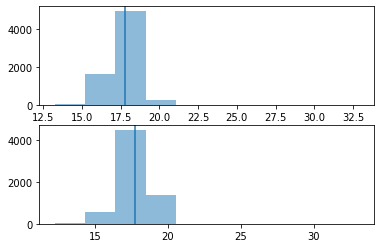

In [5]:
plt.subplot(211)
plt.hist(get_cw(petro)['petroMag_u'], alpha=0.5)
plt.axvline(np.mean(get_cw(petro)['petroMag_u']))

plt.subplot(212)
plt.hist(get_ccw(petro)['petroMag_u'], alpha=0.5)
plt.axvline(np.mean(get_ccw(petro)['petroMag_u']))

plt.show()


In [6]:
r_1, p_1 = stats.pearsonr(get_cw(exponential)['expRad_z'], get_cw(exponential)['expMag_z'])
r_2, p_2 = stats.pearsonr(get_ccw(exponential)['expRad_z'], get_ccw(exponential)['expMag_z'])

print(r_1, p_1)
print(r_2, p_2)

-0.6421278241896067 0.0
-0.6512411205102366 0.0


In [84]:
data_df = pd.concat(df_list, axis=1)
data_df = data_df.loc[:,~data_df.columns.duplicated()]
sig_cw = get_cw(data_df).loc[:, data_df.columns.isin(significant_cols)]
sig_ccw = get_ccw(data_df).loc[:, data_df.columns.isin(significant_cols)]

print(sig_cw.head(), sig_ccw.head())

    deVAB_u  deVMag_u  deVMag_r  deVMag_i  deVMag_z   lnLDeV_u    lnLDeV_g  \
0  0.749979  17.67133  16.10062  15.81216  15.56475  -14.54737  -1086.2860   
1  0.623883  17.13852  15.54738  15.21099  14.94517  -31.61773  -1684.6590   
2  0.737598  17.70563  16.10127  15.76881  15.60999  -18.39839   -875.3063   
3  0.999919  21.15541  13.89373  13.45920  13.22884 -597.47330 -17314.9800   
4  0.660081  16.80583  14.99597  14.63990  14.48875 -122.33630  -4019.9790   

    lnLDeV_r   lnLDeV_i    lnLDeV_z  ...  lnLStar_z       u_u       u_g  \
0  -1144.432   -898.877   -97.56339  ...  -2737.532  0.058788  0.047679   
1  -2305.753  -1780.849  -157.24980  ...  -3190.097  0.020108  0.001640   
2  -1618.459  -1442.119  -154.99450  ...  -2721.289 -0.011407 -0.028925   
3 -28933.040 -27342.970 -5996.98200  ... -26195.280  0.003226 -0.000169   
4  -3808.570  -2992.993  -498.35700  ...  -8797.192  0.013837  0.017112   

        u_r       u_i       u_z   texture_g  texture_r  texture_i  texture_z  
0

In [89]:
sig_cw_u = get_band(sig_cw, 'u')
sig_cw_g = get_band(sig_cw, 'g')
sig_cw_r = get_band(sig_cw, 'r')
sig_cw_i = get_band(sig_cw, 'i')
sig_cw_z = get_band(sig_cw, 'z')

print(sig_cw_u.head())

    deVAB_u  deVMag_u   lnLDeV_u  fracDeV_u   expAB_u  expMag_u  fiberMag_u  \
0  0.749979  17.67133  -14.54737   0.000000  0.763848  18.36922    20.84930   
1  0.623883  17.13852  -31.61773   0.003950  0.625797  17.86237    21.10176   
2  0.737598  17.70563  -18.39839   0.060664  0.764896  18.33509    20.94494   
3  0.999919  21.15541 -597.47330   1.000000  0.999790  21.15638    20.83311   
4  0.660081  16.80583 -122.33630   0.000000  0.696476  17.45180    20.80417   

     isoB_u  isoBGrad_u     mE2_u  petroMag_u  lnLStar_u       u_u  
0  14.20932    1.358306  0.144519    18.36360  -298.2772  0.058788  
1  17.33220    1.402781 -0.102866    17.97533  -362.5707  0.020108  
2  14.86448    1.554335 -0.034168    18.45811  -217.1804 -0.011407  
3  14.00088    0.474576  0.379406    32.80554  -594.2573  0.003226  
4  18.82773    1.971331  0.366271    17.68456  -748.8083  0.013837  


In [91]:
sig_ccw_u = get_band(sig_ccw, 'u')
sig_ccw_g = get_band(sig_ccw, 'g')
sig_ccw_r = get_band(sig_ccw, 'r')
sig_ccw_i = get_band(sig_ccw, 'i')
sig_ccw_z = get_band(sig_ccw, 'z')

print(sig_ccw_i.head())

      deVMag_i   lnLDeV_i  fracDeV_i  expMag_i  fiberMag_i     mE2_i  \
6941  13.25383 -12320.210   0.320908  13.50528    16.71336 -0.461893   
6942  14.98659  -1736.877   0.095975  15.50668    18.26843 -0.082913   
6943  14.91841  -1214.153   0.697926  15.42736    17.81665 -0.212469   
6944  15.42695  -1386.449   0.589367  15.96630    18.07060  0.028138   
6945  13.44821 -15980.740   0.036203  13.79871    17.21415  0.196975   

       mRrCc_i    mCr4_i  petroMag_i  lnLStar_i       u_i   texture_i  
6941  338.6712  2.436728    13.48116 -118246.50 -0.022239  1142.10900  
6942  216.0908  2.343481    15.55669  -17911.77 -0.006283    35.04709  
6943   81.0212  2.607456    15.28130  -30684.31 -0.032203    18.50270  
6944  107.3568  2.570138    15.81912  -19984.45 -0.000884    28.17815  
6945  445.6491  2.345481    13.83571 -102474.50  0.006393   269.84690  


In [98]:
print(sig_cw_g.head(), sig_ccw_g.head())
#pd.Expanding.corr(sig_cw_g, sig_ccw_g, pairwise=True)
print(sig_cw_g.corrwith(sig_ccw_g))

#corr_u = get_band(sig_cw, 'u').corrwith(get_band(sig_ccw, 'u'))
#print(corr_u)

     lnLDeV_g  fracDeV_g  expMag_g  fiberMag_g  isoBGrad_g     mE2_g  \
0  -1086.2860   0.243298  17.08591    19.19732    1.079821  0.178863   
1  -1684.6590   0.029808  16.61585    19.59298    1.122088 -0.035146   
2   -875.3063   0.880019  17.10317    18.99400    1.222248 -0.087338   
3 -17314.9800   0.335671  14.29791    19.08021    5.918584  0.255397   
4  -4019.9790   0.145344  16.02371    18.92995    2.239705  0.375643   

     mCr4_g  petroMag_g  lnLStar_g       u_g   texture_g  
0  2.283365    17.04643 -11178.190  0.047679   19.788300  
1  2.258797    16.70596 -13956.590  0.001640    7.298114  
2  2.642191    16.99524  -9824.829 -0.028925   26.925100  
3  2.401254    14.25867 -64911.760 -0.000169  243.665900  
4  2.333222    16.04655 -33918.780  0.017112   84.379300           lnLDeV_g  fracDeV_g  expMag_g  fiberMag_g  isoBGrad_g     mE2_g  \
6941 -11948.5800   0.219255  14.40859    17.89543    2.133255 -0.506079   
6942   -856.4148   0.000000  16.41179    19.42507    1.436781 -